In [1]:
##
# notebook to analyze px4 ulog files
# data messages:
# vx: velocity in x (world NED)
# vy: velocity in y (world NED)
# vx_b_yaw: velocity in x (body NED without tilt)
# vy_b_yaw: velocity in y (body NED without tilt)
# v_airx: airspeed estimate in x (world NED)
# v_airy: airspeed estimate in y (world NED)
# v_airx_body_yaw: airspeed estimate in x (body NED without tilt)
# v_airy_body_yaw: airspeed estimate in y (body NED without tilt)
# baro_alt: barometric altitude - static altitude
###
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import glob
from px4tools import logdynamicpressure as ldp

attempting to monkey patch pandas timedelta series plotting
monkey patch suceeded


In [2]:
# ulog filename
path = 'ulog/dynamic_alt'
files = glob.glob(os.path.join(path,"*.ulg"))

In [3]:
# generate data
df = pd.DataFrame()
for file in files:
    data = ldp.load_data(file)
    data = ldp.estimate_airspeed(data)
    data = ldp.prepare_dynamicaltitude_data(data)
    df = df.append(data)
df.index = list(range(len(df))) 

In [5]:
# split data into positive and negative region
df['vx_b_yaw_p'] = df.vx_b_yaw
df['vx_b_yaw_n'] = df.vx_b_yaw
df['vy_b_yaw_p'] = df.vy_b_yaw
df['vy_b_yaw_n'] = df.vy_b_yaw
df.loc[df.vx_b_yaw < 0, 'vx_b_yaw_p'] = 0
df.loc[df.vx_b_yaw >= 0, 'vx_b_yaw_n'] = 0
df.loc[df.vy_b_yaw < 0, 'vy_b_yaw_p'] = 0
df.loc[df.vy_b_yaw >= 0, 'vy_b_yaw_n'] = 0

In [6]:
data = pd.DataFrame({'X1': df.vx_b_yaw,
                    'X2': df.vy_b_yaw,
                     'X3': df.vx_b_yaw_p**2,
                     'X4': df.vx_b_yaw_n**2,
                     'X5': df.vy_b_yaw_p**2,
                     'X6': df.vy_b_yaw_n**2,
                     'Z':df.baro_alt})

In [7]:
model = ols("Z ~ X1 + X2 + X3 + X4 + X5 + X6", data).fit()

In [8]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Z   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     50.50
Date:                Tue, 21 Feb 2017   Prob (F-statistic):           3.30e-60
Time:                        14:59:08   Log-Likelihood:                -4554.5
No. Observations:                4114   AIC:                             9123.
Df Residuals:                    4107   BIC:                             9167.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0135      0.014     -0.962      0.3

In [9]:
coeff = model._results.params
print(coeff)

[-0.01346987  0.00873964 -0.00807383  0.00156748  0.00418715  0.0043546
  0.00531495]


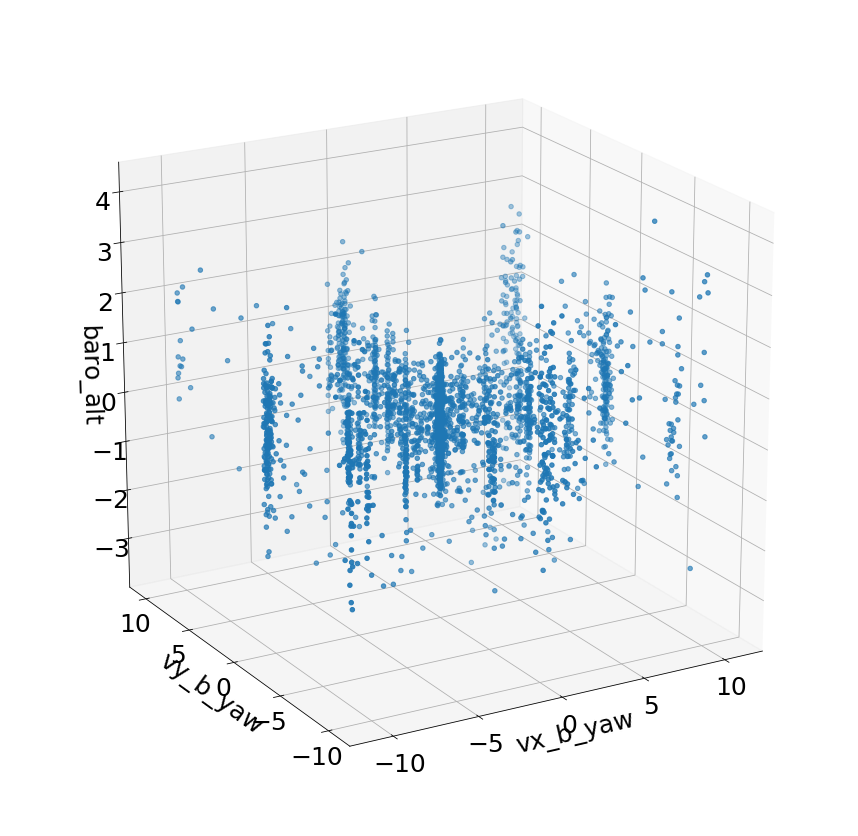

In [10]:
#plot data using ground velocity in body-yaw frame
fig = plt.figure(figsize=(15,15))
plt.rc('font', size=25)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
ax = fig.gca(projection='3d')
ax.scatter(df.vx_b_yaw, df.vy_b_yaw, df.baro_alt)
ax.view_init(20,-120)
ax.set_xlabel('vx_b_yaw')
ax.set_ylabel('vy_b_yaw')
ax.set_zlabel('baro_alt')
plt.show()

In [11]:
# generate data with new model
x = np.linspace(-14,14,60)
X,Y = np.meshgrid(x,x)
X_p,Y_p = np.meshgrid(x,x)
X_n,Y_n = np.meshgrid(x,x)

In [12]:
for x in X_p:
    x[x < 0] = 0
for x in X_n:
    x[x >=0] = 0
for y in Y_p:
    y[y < 0] = 0
for y in Y_n:
    y[y >=0] = 0

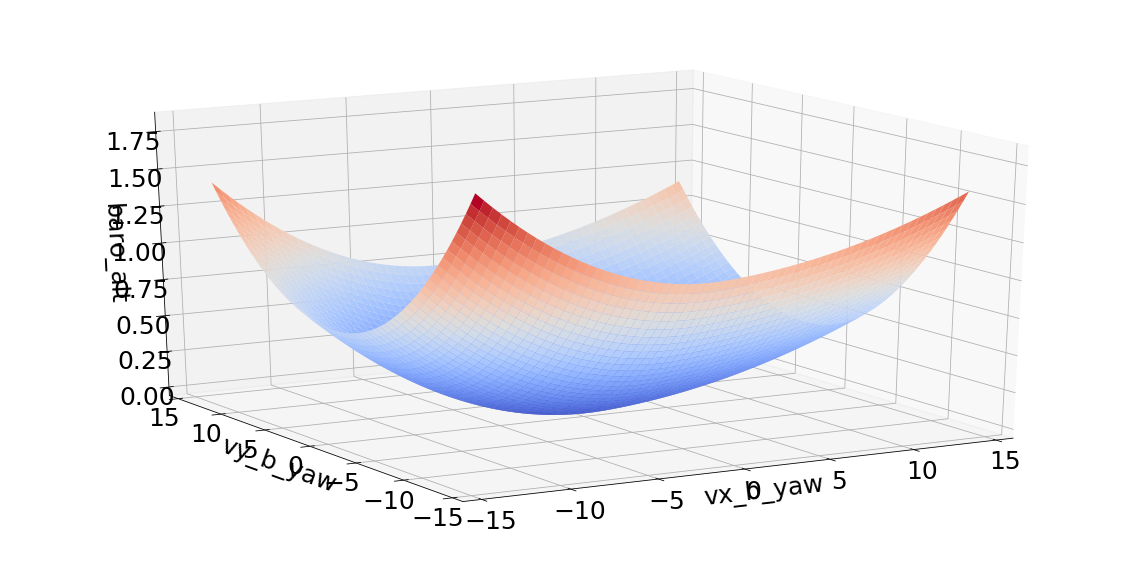

In [19]:
# generate data with new model
Z = coeff[0] + coeff[1]*X + coeff[2]*Y + coeff[3]*X_p**2 + coeff[4]*X_n**2+ coeff[5]*Y_p**2 + coeff[6]*Y_n**2
fig = plt.figure(figsize=(20,10))
plt.rc('font', size=25)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm,
                       rstride=1, cstride=1)
ax.view_init(20, -120)
ax.set_xlabel('vx_b_yaw')
ax.set_ylabel('vy_b_yaw')
ax.set_zlabel('baro_alt')
plt.show()